# LSTM Stock Predictor Using Closing Prices
In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price.

We are:

Preparing the data for training and testing
Building and train a custom LSTM RNN
Evaluating the performance of the model

# Data Preparation
In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:

Use the window_data function to generate the X and y values for the model.
Split the data into 70% training and 30% testing
Apply the MinMaxScaler to the X and y values
Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:
reshape((X_train.shape[0], X_train.shape[1], 1))

In [11]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [12]:
# Setting the random seed for reproducibility
# Note: It is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [13]:
# Loading the fear and greed sentiment data for Bitcoin
df = pd.read_csv('vix.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns= "Open")
df = df.rename(columns={'Close': 'vix_value'})
df['vix_value']=df['vix_value'].astype(int) 
df.index = df.index.normalize()
df.head()

,vix_value
Date,
2016-01-04,44
2016-01-05,44
2016-01-06,43
2016-01-07,43
2016-01-08,42


In [15]:
# Loading the historical closing prices for Bitcoin
df2 = pd.read_csv('ccl_price.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.index = df2.index.normalize()
df2.tail()

Date
2020-12-23    20.94
2020-12-24    20.84
2020-12-28    21.71
2020-12-29    21.43
2020-12-30    21.79
Name: Close, dtype: float64

In [16]:
# Joining the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,vix_value,Close
Date,,
2020-12-23,655,20.94
2020-12-24,695,20.84
2020-12-28,649,21.71
2020-12-29,640,21.43
2020-12-30,645,21.79


In [17]:
df.head()

,vix_value,Close
Date,,
2016-01-04,44,54.20
2016-01-05,44,53.68
2016-01-06,43,53.52
2016-01-07,43,52.39
2016-01-08,42,52.05


In [18]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [47]:
# Predicting Closing Prices using a 10 day window of previous closing prices
# Then, experimenting with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 1000

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [48]:
# Using 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [49]:
from sklearn.preprocessing import MinMaxScaler
# Using the MinMaxScaler to scale data between 0 and 1.
# Creating a MinMaxScaler object
scaler = MinMaxScaler()
# Fitting the MinMaxScaler object with the features data X
scaler.fit(X)

# Scaling the features training and testing sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scaling the target training and testing sets
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [50]:
# Reshaping the features for the model
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Printing some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train_scaled[:3]} \n")
print (f"X_test sample values:\n{X_test_scaled[:3]}")

X_train sample values:
[[[0.96238245]
  [0.92163009]
  [0.90909091]
  ...
  [0.96152971]
  [0.98543137]
  [0.98702481]]

 [[0.92163009]
  [0.90909091]
  [0.82053292]
  ...
  [0.98543137]
  [0.98702481]
  [0.98702481]]

 [[0.90909091]
  [0.82053292]
  [0.79388715]
  ...
  [0.98702481]
  [0.98702481]
  [0.97996813]]] 

X_test sample values:
[[[0.35658307]
  [0.33934169]
  [0.31191223]
  ...
  [0.23491919]
  [0.22057819]
  [0.22558616]]

 [[0.33934169]
  [0.31191223]
  [0.3346395 ]
  ...
  [0.22057819]
  [0.22558616]
  [0.2212611 ]]

 [[0.31191223]
  [0.3346395 ]
  [0.30564263]
  ...
  [0.22558616]
  [0.2212611 ]
  [0.22490326]]]


## Build and Train the LSTM RNN
In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:

Define the model architecture
Compile the model
Fit the model to the training data

## Hints:

You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model.

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [52]:
# Building the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# No need to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Defining the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train_scaled.shape[1], 1)))
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [53]:
# Compiling the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [54]:
# Summarizing the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1000, 30)          3840      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000, 30)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1000, 30)          7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000, 30)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [56]:
# Training the model
# Using at least 10 epochs
# Do not shuffle the data
# Experiementing with the batch size, but a smaller batch size is recommended
model.fit(X_train_scaled, y_train_scaled, epochs=10, shuffle=False, batch_size=10, verbose=1)

Epoch 1/10
18/18 [==============================] - 9s 488ms/step - loss: 0.0352
Epoch 2/10
18/18 [==============================] - 10s 555ms/step - loss: 0.0150
Epoch 3/10
18/18 [==============================] - 12s 655ms/step - loss: 0.0306
Epoch 4/10
18/18 [==============================] - 12s 664ms/step - loss: 0.0148
Epoch 5/10
18/18 [==============================] - 13s 700ms/step - loss: 0.0302
Epoch 6/10
18/18 [==============================] - 13s 703ms/step - loss: 0.0151
Epoch 7/10
18/18 [==============================] - 13s 704ms/step - loss: 0.0274
Epoch 8/10
18/18 [==============================] - 14s 754ms/step - loss: 0.0139
Epoch 9/10
18/18 [==============================] - 13s 713ms/step - loss: 0.0115
Epoch 10/10
18/18 [==============================] - 13s 713ms/step - loss: 0.0084


### Model Performance
In this section, you will evaluate the model using the test data.

You will need to:

1. Evaluate the model using the X_test and y_test data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values.
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the inverse_transform function to the predicted and y_test values to recover the actual closing prices.

In [57]:
# Evaluating the model
model.evaluate(X_test_scaled, y_test_scaled)

3/3 [==============================] - 1s 94ms/step - loss: 0.0036


0.00355030526407063

In [58]:
# Making some predictions
predicted = model.predict(X_test_scaled)

In [59]:
# Recovering the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

In [60]:
# Creating a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-09-14,17.69,15.468941
2020-09-15,17.85,15.634907
2020-09-16,15.93,15.779648
2020-09-17,16.46,15.872553
2020-09-18,16.24,15.911991


<AxesSubplot:title={'center':'Real Vs. Predicted Prices'}, xlabel='Date'>

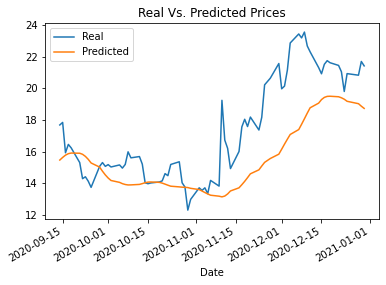

In [61]:
# Plotting the real vs predicted values as a line chart
stocks.plot(title="Real Vs. Predicted Prices")